## Test on Dataset 3 attention mask trained on Dataset 1

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

sys.path.append('..')

from seismicpro.batchflow import Dataset, DatasetIndex, Pipeline, B, V, F
from seismicpro.batchflow.models.tf import UNet

from seismicpro.src import (SeismicBatch, FieldIndex, TraceIndex, KNNIndex, CustomIndex,
                            seismic_plot, spectrum_plot, merge_segy_files)

from unet import u_net, conv_block

%env CUDA_VISIBLE_DEVICES=1

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


env: CUDA_VISIBLE_DEVICES=1


Index Dataset 3

In [2]:
path_raw = '/notebooks/egor/noise_dataset_3/5_NA-gr_input_raw.sgy'
path_lift = '/notebooks/egor/noise_dataset_3/5_NA-gr_output_lift5.sgy'

index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)
         .merge(FieldIndex(name='lift', path=path_lift)))
index.head()

,TraceNumber,offset,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw,lift,lift
FieldRecord,,,,,,
10407,1956,79,1,/notebooks/egor/noise_dataset_3/5_NA-gr_input_...,1,/notebooks/egor/noise_dataset_3/5_NA-gr_output...
10407,623,3347,2215,/notebooks/egor/noise_dataset_3/5_NA-gr_input_...,2215,/notebooks/egor/noise_dataset_3/5_NA-gr_output...
10407,698,3348,2216,/notebooks/egor/noise_dataset_3/5_NA-gr_input_...,2216,/notebooks/egor/noise_dataset_3/5_NA-gr_output...
10407,1037,3348,2217,/notebooks/egor/noise_dataset_3/5_NA-gr_input_...,2217,/notebooks/egor/noise_dataset_3/5_NA-gr_output...
10407,1148,3348,2218,/notebooks/egor/noise_dataset_3/5_NA-gr_input_...,2218,/notebooks/egor/noise_dataset_3/5_NA-gr_output...


Load soft sigmoid model trained on Dataset 1

In [3]:
config = tf.ConfigProto()
graph = tf.Graph()
with graph.as_default():
    trace_in = tf.placeholder('float', shape=(None, 3000, 1), name='trace_in')
    trace_offset = tf.placeholder('float', shape=(None, 1), name='trace_offset')
    target = tf.placeholder('float', shape=(None, 3000, 1), name='target')
    balance = tf.placeholder('float', name='balance')
    learning_rate = tf.placeholder('float', name='learning_rate')
    is_training = tf.placeholder(tf.bool, name='is_training')
    
    with tf.variable_scope("attention_scope"):
        attention = u_net(trace_in, depth=3, filters=8, kernel_size=3,
                          activation='elu', is_training=is_training)
        attention = conv_block(attention, 'c', filters=1, kernel_size=3)
        attention = conv_block(attention, 'ca', filters=1, kernel_size=3,
                               activation='sigmoid')
        print('attention', attention.get_shape())

        attention_sum = tf.reduce_sum(attention, axis=1)
        print('attention_sum', attention_sum.get_shape())
        
        sigm_x = tf.fill(tf.shape(attention)[:2], 0.0)
        sigm_x = tf.add(sigm_x, -tf.range(0, tf.cast(tf.shape(attention)[1], 'float'), dtype='float'))

        shift_in = tf.concat([attention_sum, trace_offset], axis=1)
        print('shift_in', shift_in.get_shape())
        shift_in = tf.layers.dense(shift_in, 16, activation=tf.nn.elu)
        shift_out = tf.layers.dense(shift_in, 2, activation=tf.nn.relu)
    
    sigm_x = tf.divide(tf.add(sigm_x, shift_out[:, :1]), 1 + shift_out[:, 1:2])

#     sigm_x = tf.add(sigm_x, attention_sum)
    
    attention_sigmoid = tf.expand_dims(tf.sigmoid(sigm_x), -1)
    print('attention_sigmoid', attention_sigmoid.get_shape())
    
    with tf.variable_scope("lift_scope"):
        lift_trace = u_net(trace_in, depth=5, filters=16, kernel_size=7,
                          activation='elu', is_training=is_training)
        lift_trace = conv_block(lift_trace, 'c', filters=1, kernel_size=3)
    print('lift', lift_trace.get_shape())
    
    predict = (tf.multiply(trace_in, attention_sigmoid) +
               tf.multiply(lift_trace, 1 - attention_sigmoid))
    loss = (tf.losses.absolute_difference(target, predict) +
            balance * tf.reduce_mean(1 - attention_sigmoid))
    
    masked_loss = tf.losses.absolute_difference(target, predict,
                                                reduction=tf.losses.Reduction.SUM,
                                                weights=(1 - attention_sigmoid) / tf.reduce_sum(1 - attention_sigmoid))

    optimizer = tf.train.AdamOptimizer(learning_rate)
    lift_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                  scope='lift_scope')
    attention_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope='attention_scope')

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        step_attention = optimizer.minimize(loss, var_list=attention_vars)
        step_lift = optimizer.minimize(loss, var_list=lift_vars)
        step_masked_lift = optimizer.minimize(masked_loss, var_list=lift_vars)
    
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, './demo_attention_model_S.ckpt')

input (?, 3000, 1)
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
conv_block_0 (?, 3000, 8)
pool_0 (?, 1500, 8)
conv_block_1 (?, 1500, 16)
pool_1 (?, 750, 16)
conv_block_2 (?, 750, 32)
pool_2 (?, 375, 32)
bottom_conv_block_3 (?, 375, 64)
up_2 (?, 750, 64)
concat_3 (?, 750, 96)
up_conv_block_3 (?, 750, 32)
up_1 (?, 1500, 32)
concat_2 (?, 1500, 48)
up_conv_block_2 (?, 1500, 16)
up_0 (?, 3000, 16)
concat_1 (?, 3000, 24)
up_conv_block_1 (?, 3000, 8)
attention (?, 3000, 1)
attention_sum (?, 1)
shift_in (?, 2)
attention_sigmoid (?, 3000, 1)
input (?, 3000, 1)
conv_block_0 (?, 3000, 16)
pool_0 (?, 1500, 16)
conv_block_1 (?, 1500, 32)
pool_1 (?, 750, 32)
conv_block_2 (?, 750, 64)
pool_2 (?, 375, 64)
conv_block_3 (?, 375, 128)
pool_3 (?, 188, 128)
conv_block_4 (?, 188, 256)
pool_4 (?, 94, 256)
bottom_conv_block_5 (?, 94, 512)
up_4 (?, 188, 512)
concat_5 (?, 188, 768)
up_conv_block_5 (?, 188, 256)
up_3 (?, ?, 256)
concat_4 (?, 375, 384)
up_conv_block_4 (?, 375

Evaluate on a sample shot seismogram

In [22]:
i = 19
scale_coef = 0.00045

test_set = Dataset(TraceIndex(index.create_subset(index.indices[i: i+1])),
                   SeismicBatch)

res_stack = []
x_stack = []
y_stack = []
offset_stack = []
batch_size = 1000

for _ in range(1 + len(test_set) // batch_size):
    batch = (test_set.next_batch(batch_size, n_epochs=1)
             .load(components=('raw', 'lift'), fmt='segy',
                   tslice=np.arange(3000)))
    
    x = scale_coef * np.expand_dims(np.vstack(batch.raw), -1)
    y = scale_coef * np.expand_dims(np.vstack(batch.lift), -1)
    offset = batch.index.get_df()['offset'].values[:, np.newaxis]
    
    res = sess.run([attention, predict, lift_trace, attention_sigmoid, shift_out],
                   feed_dict={trace_in: x,
                              trace_offset: offset, 
                              is_training: False})
    
    res_stack.append(res)
    x_stack.append(x)
    y_stack.append(y)
    offset_stack.append(offset)

In [23]:
order = np.argsort(np.vstack(offset_stack)[:, 0])
att = np.squeeze(np.concatenate([t[0] for t in res_stack]))[order]
out = np.squeeze(np.concatenate([t[1] for t in res_stack]))[order]
out_lift = np.squeeze(np.concatenate([t[2] for t in res_stack]))[order]
att_sigm = np.squeeze(np.concatenate([t[3] for t in res_stack]))[order]
raw = np.squeeze(np.concatenate(x_stack))[order]
lift = np.squeeze(np.concatenate(y_stack))[order]
sigm_params = np.squeeze(np.concatenate([t[4] for t in res_stack]))[order]

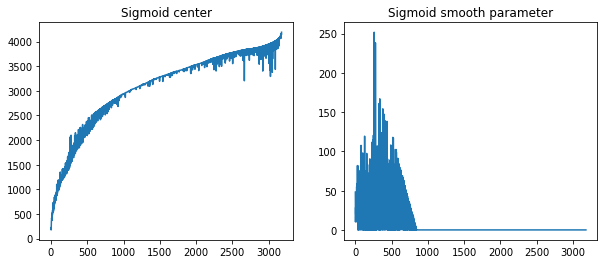

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(sigm_params[:, 0])
ax[1].plot(sigm_params[:, 1])
ax[0].set_title('Sigmoid center')
ax[1].set_title('Sigmoid smooth parameter')
plt.show()

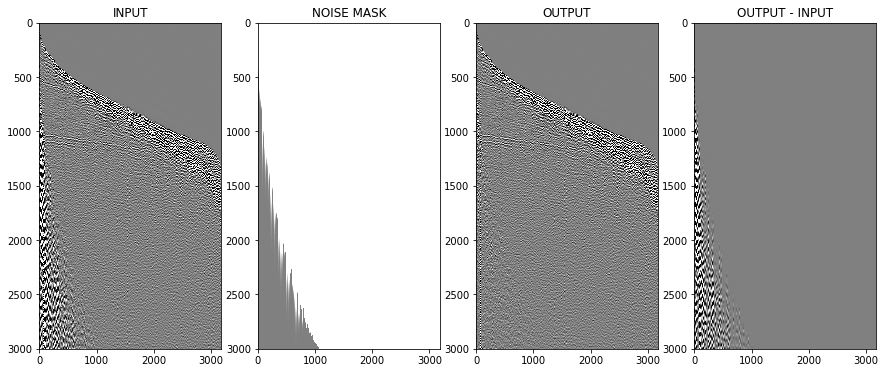

In [25]:
cv = 0.5
seismic_plot([raw, att_sigm, out, out - raw],
             names=['INPUT', 'NOISE MASK', 'OUTPUT', 'OUTPUT - INPUT'],
             figsize=(15, 6), vmin=-cv, vmax=cv, cmap='gray')

Thresholoding lift - raw difference: 

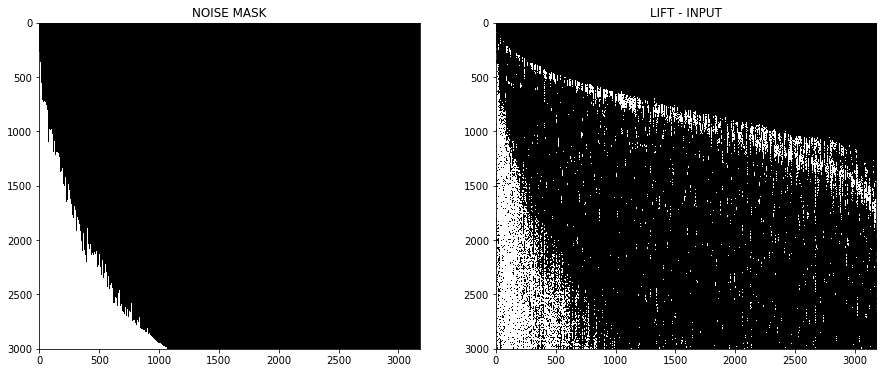

In [30]:
seismic_plot([np.rint(att_sigm)==0, abs(lift - raw) > 0.1],
             names=['NOISE MASK', 'LIFT - INPUT'],
             figsize=(15, 6), vmin=0, vmax=1, cmap='gray')

Definition of IOU metric

In [11]:
def iou(a, b):
    return np.sum(a & b) / np.sum(a | b)

Evaluate IOU on a sample shot seismogram for many thresholds

In [12]:
thrs = np.arange(0, 0.3, 0.01)
vals = np.array([iou(np.rint(att_sigm) == 0, abs(lift - raw) > p) for p in thrs])

Best threshold is 0.1


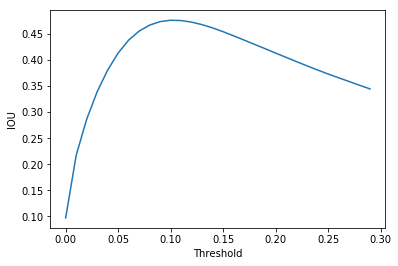

In [13]:
plt.plot(thrs, vals)
plt.xlabel('Threshold'), plt.ylabel('IOU')
print('Best threshold is', thrs[np.argmax(vals)])
plt.show()

Evaluate IOU for all seismograms

In [16]:
thrs = np.arange(0, 0.3, 0.01)
iou_metrics = []
scale_coef = 0.00045

for i in tqdm(range(len(index))):
    test_set = Dataset(TraceIndex(index.create_subset(index.indices[i: i+1])),
                       SeismicBatch)

    res_stack = []
    x_stack = []
    y_stack = []
    batch_size = 1000

    for _ in range(1 + len(test_set) // batch_size):
        batch = (test_set.next_batch(batch_size, n_epochs=1)
                 .load(components=('raw', 'lift'), fmt='segy',
                       tslice=np.arange(3000)))

        x = scale_coef * np.expand_dims(np.vstack(batch.raw), -1)
        y = scale_coef * np.expand_dims(np.vstack(batch.lift), -1)
        offset = batch.index.get_df()['offset'].values[:, np.newaxis]

        res = sess.run([attention_sigmoid],
                       feed_dict={trace_in: x,
                                  trace_offset: offset, 
                                  is_training: False})

        res_stack.append(res)
        x_stack.append(x)
        y_stack.append(y)
        
    att_sigm = np.squeeze(np.concatenate([t[0] for t in res_stack]))
    raw = np.squeeze(np.concatenate(x_stack))
    lift = np.squeeze(np.concatenate(y_stack))

    vals = np.array([iou(np.rint(att_sigm) == 0, abs(lift - raw) > p)
                     for p in thrs])
    
    iou_metrics.append(vals)
    
iou_metrics = np.array(iou_metrics)

100%|██████████| 201/201 [23:54<00:00,  7.14s/it]


IOU metrics for sample seismograms

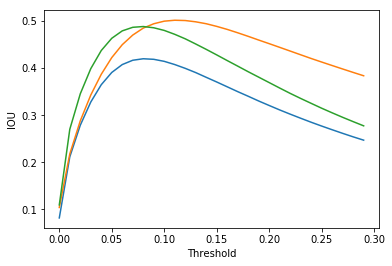

In [17]:
plt.plot(thrs, iou_metrics[9])
plt.plot(thrs, iou_metrics[31])
plt.plot(thrs, iou_metrics[20])
plt.xlabel('Threshold'), plt.ylabel('IOU')
plt.show()

Plot of maximal IOU for each shot seismogram

Mean maximal IOU: 0.4552861106583608


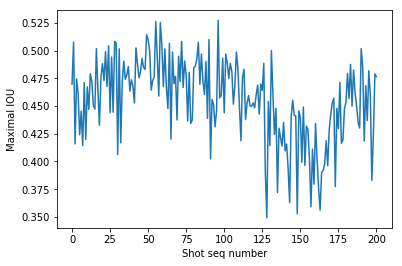

In [18]:
plt.plot(np.max(iou_metrics, axis=1))
plt.xlabel('Shot seq number')
plt.ylabel('Maximal IOU')
print('Mean maximal IOU:', np.max(iou_metrics, axis=1).mean())
plt.show()

Plot of averaged (across seismigrams) IOU for various thresholds

Optimal threshold: 0.11
IOU at optimal threshold: 0.4489709962809736


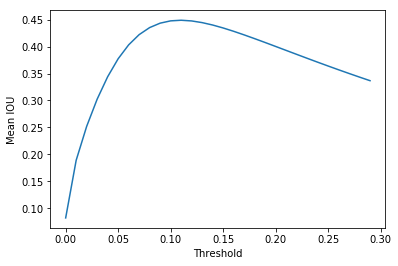

In [20]:
plt.plot(thrs, np.mean(iou_metrics, axis=0))
plt.xlabel('Threshold')
plt.ylabel('Mean IOU')
print('Optimal threshold:', 0.01 * np.argmax(np.mean(iou_metrics, axis=0)))
print('IOU at optimal threshold:', np.max(np.mean(iou_metrics, axis=0)))
plt.show()